In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 


Load DataSet 

In [6]:
df=pd.read_csv("Social_Network_Ads.csv")
df.head(10)

,User ID,Gender,Age,EstimatedSalary,Purchased
0,15624510,Male,19,19000,0
1,15810944,Male,35,20000,0
2,15668575,Female,26,43000,0
3,15603246,Female,27,57000,0
4,15804002,Male,19,76000,0
5,15728773,Male,27,58000,0
6,15598044,Female,27,84000,0
7,15694829,Female,32,150000,1
8,15600575,Male,25,33000,0
9,15727311,Female,35,65000,0


Data Preprocessing

In [8]:
##1.Handling Missing Values 
df.isnull().sum()

User ID            0
Gender             0
Age                0
EstimatedSalary    0
Purchased          0
dtype: int64

As theres no missing values so no need to handle this

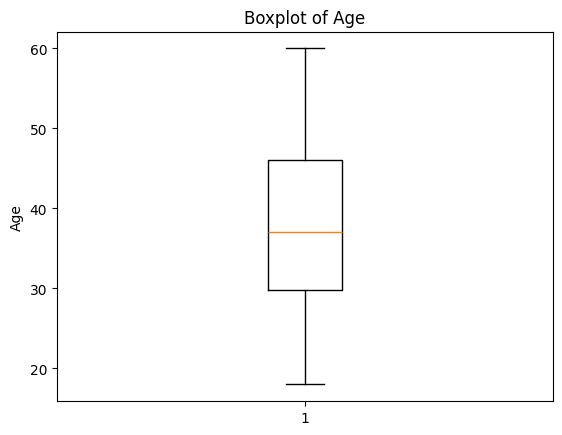

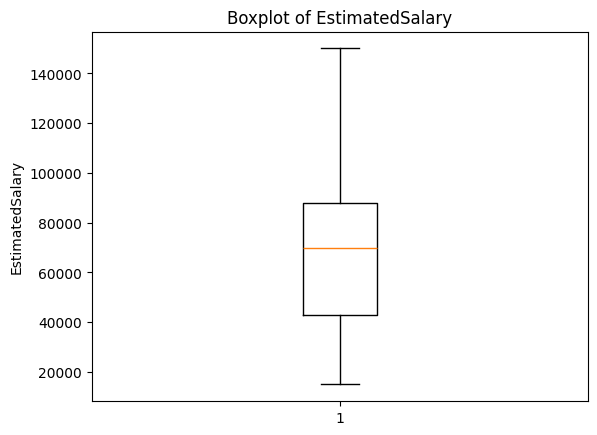

In [15]:
##2.Outlier Detection
for col in ["Age","EstimatedSalary"]:
    plt.boxplot(df[col])
    plt.title(f"Boxplot of {col}")
    plt.ylabel(col)
    plt.show()

In [16]:
print(f"Before Outliers Removal {df.shape}")

Before Outliers Removal (400, 5)


In [17]:
for col in ["Age","EstimatedSalary"]:
  Q1=df[col].quantile(0.25)
  Q3=df[col].quantile(0.75)
  IQR=Q3-Q1
  lowr_bound=Q1-1.5*IQR
  uppr_bound=Q3+1.5*IQR
  df=df[(df[col]>=lowr_bound) &(df[col]<=uppr_bound)]
print(f"After Outliers Removal{df.shape}") ##There was no outliers 

After Outliers Removal(400, 5)


Feature Engineering 

<Axes: xlabel='Gender', ylabel='count'>

<Axes: xlabel='Gender', ylabel='count'>

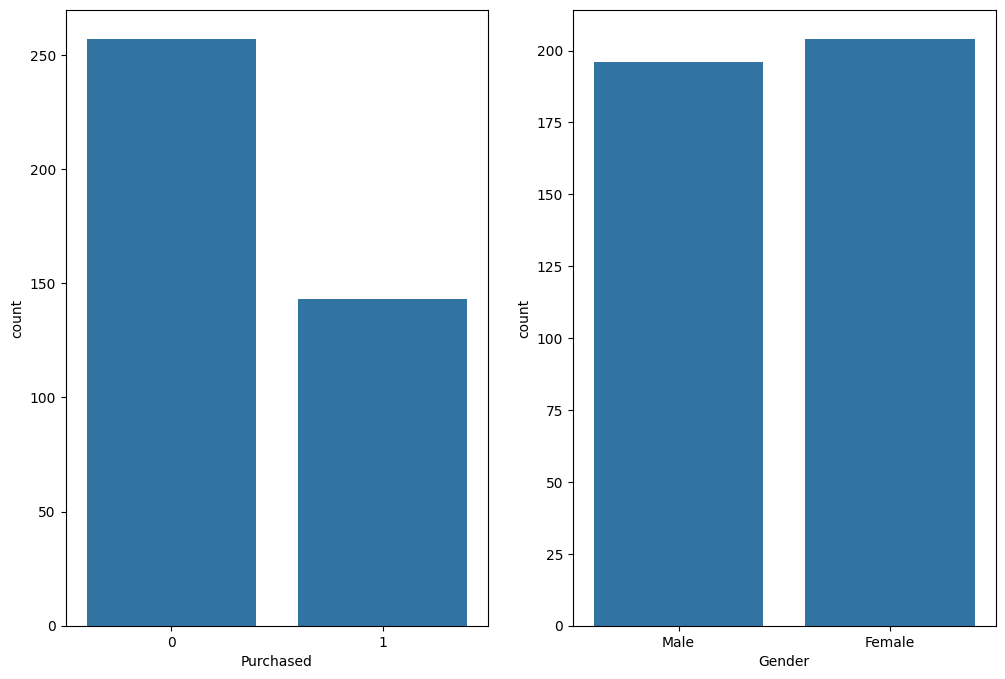

In [19]:
##Checking Class imbalance

fig,axes=plt.subplots(1,2,figsize=(12,8))
sns.countplot(x="Purchased",data=df,ax=axes[0])
sns.countplot(x="Gender",data=df,ax=axes[1])



In [23]:
df["Purchased"].value_counts(normalize=True)*100

Purchased
0    64.25
1    35.75
Name: proportion, dtype: float64

Mild imbalance in Purchase class


In [21]:
df.shape

(400, 5)

In [37]:
##Creating New Features that can contribute in prediction
df["AgeGroup"]=pd.cut(df["Age"],bins=[0,30,45,100],labels=["Young","Mid","Old"])

df["SalaryPerAge"]=df["EstimatedSalary"]/df["Age"]
df.head()

,User ID,Gender,Age,EstimatedSalary,Purchased,AgeGroup,SalaryPerAge
3,15603246,Female,27,57000,0,Young,2111.111111
4,15804002,Male,19,76000,0,Young,4000.000000
5,15728773,Male,27,58000,0,Young,2148.148148
6,15598044,Female,27,84000,0,Young,3111.111111
7,15694829,Female,32,150000,1,Mid,4687.500000


In [34]:
df.head()

,User ID,Gender,Age,EstimatedSalary,Purchased
3,15603246,Female,27,57000,0
4,15804002,Male,19,76000,0
5,15728773,Male,27,58000,0
6,15598044,Female,27,84000,0
7,15694829,Female,32,150000,1


Data Preprocessing 

In [ ]:
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline 
X=df.drop(columns=["Purchased","User ID"])
y=df["Purchased"]


(     Gender  Age  EstimatedSalary AgeGroup  SalaryPerAge
 3    Female   27            57000    Young   2111.111111
 4      Male   19            76000    Young   4000.000000
 5      Male   27            58000    Young   2148.148148
 6    Female   27            84000    Young   3111.111111
 7    Female   32           150000      Mid   4687.500000
 ..      ...  ...              ...      ...           ...
 395  Female   46            41000      Old    891.304348
 396    Male   51            23000      Old    450.980392
 397  Female   50            20000      Old    400.000000
 398    Male   36            33000      Mid    916.666667
 399  Female   49            36000      Old    734.693878
 
 [397 rows x 5 columns],
 3      0
 4      0
 5      0
 6      0
 7      1
       ..
 395    1
 396    1
 397    1
 398    0
 399    1
 Name: Purchased, Length: 397, dtype: int64)

In [ ]:
num_cols=["Age","EstimatedSalary","SalaryPerAge"]
cat_cols=["Gender","AgeGroup"]
preprocessor=ColumnTransformer(
    transformers=[('num',StandardScaler(),num_cols),
                  ('cat',OneHotEncoder(drop='first'),cat_cols)
                  
                  ]
)


In [45]:
from sklearn.model_selection import train_test_split 
X_train,X_test,y_train,y_test=train_test_split(X_scaled,y,test_size=0.2,random_state=42) 


Pipeline Creation

In [ ]:
from sklearn.svm import SVC 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

models={
    "Logistic Regression":LogisticRegression(),
    "Random Forest":RandomForestClassifier(),
    "SVC":SVC()
}

results={}
for name,model in models.items():
    pipeline=Pipeline(
        steps=[('preprocessor',preprocessor),
               ('model',model)]
    )
    scores=cross_val_score(pipeline,X_train,y_train,cv=5,scoring='accuracy')
    results[name]=[scores.mean(),scores.std()]

# Create sorted results DataFrame
result_df=pd.DataFrame(results,index=["Mean Accuracy","Std"]).T
result_df=result_df.sort_values("Mean Accuracy",ascending=False)

print(f"Best Model: {result_df.index[0]} with accuracy {result_df.iloc[0,0]:.4f}\n")
result_df